In [26]:
# Limpieza de datos

import pandas as pd

df = pd.read_csv('../data/datos_mexico.csv')

df=df.drop(['_id','RENGLON','ENTIDAD'],axis=1)

# Combinacion de columnas

df['Poblacion de jovenes (3-14)']=df['POB_3_5']+df['POB_6_011']+df['POB_012_014']
df=df.drop(['POB_3_5','POB_6_011','POB_012_014'],axis=1)
df['Poblacion de adultos (15-64)']=df['POB_015_29']+df['POB_30_64']
df = df.drop(['POB_015_017','POB_015_019','POB_015_29','POB_015_49','POB_018_24','POB_20_24','POB_30_64'],axis=1)
df = df.rename(columns={'POB_65_MAS':'Poblacion adultos mayores (65+)'})

# Calculo de tasas de cambio por año

df['Cambio jovenes']=df['Poblacion de jovenes (3-14)'].diff().fillna(0)
df['Cambio adultos']=df['Poblacion de adultos (15-64)'].diff().fillna(0)
df['Cambio mayores']=df['Poblacion adultos mayores (65+)'].diff().fillna(0)

print(df)

    ANIO  Poblacion adultos mayores (65+)  Poblacion de jovenes (3-14)  \
0   2002                          5399307                     27773497   
1   2003                          5576695                     27829732   
2   2004                          5761262                     27861649   
3   2005                          5953231                     27858970   
4   2006                          6155725                     27830965   
5   2007                          6368873                     27795480   
6   2008                          6585485                     27758562   
7   2009                          6808607                     27724088   
8   2010                          7046284                     27705408   
9   2011                          7302545                     27706657   
10  2012                          7569447                     27709468   
11  2013                          7840039                     27692281   
12  2014                          8110

In [29]:
df.to_csv('../data/mexico.csv')

In [41]:
# Modelacion estadistica
import statsmodels.api as sm

# Asegura float en columnas usadas
cols = [
    "Poblacion de adultos (15-64)",
    "Poblacion de jovenes (3-14)",
    "Poblacion adultos mayores (65+)",
    "Cambio jovenes","Cambio adultos","Cambio mayores"
]
df[cols] = df[cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=cols)

x_J = df[["Poblacion de adultos (15-64)","Poblacion de jovenes (3-14)"]]
y_J = df["Cambio jovenes"]
x_J = sm.add_constant(x_J)
modelo_J = sm.OLS(y_J, x_J, missing="drop").fit()

x_A = df[["Poblacion de jovenes (3-14)","Poblacion de adultos (15-64)"]]
y_A = df["Cambio adultos"]
x_A = sm.add_constant(x_A)
modelo_A = sm.OLS(y_A, x_A, missing="drop").fit()

# Incluye A y E para el modelo de mayores (consistente con dyE = alpha*A - c4*E)
x_E = df[["Poblacion de adultos (15-64)", "Poblacion adultos mayores (65+)"]]
y_E = df["Cambio mayores"]
x_E = sm.add_constant(x_E)
modelo_E = sm.OLS(y_E, x_E, missing="drop").fit()

print(modelo_J.summary())
print(modelo_A.summary())
print(modelo_E.summary())

                            OLS Regression Results                            
Dep. Variable:         Cambio jovenes   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     25.30
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           8.01e-06
Time:                        11:52:26   Log-Likelihood:                -242.84
No. Observations:                  20   AIC:                             491.7
Df Residuals:                      17   BIC:                             494.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

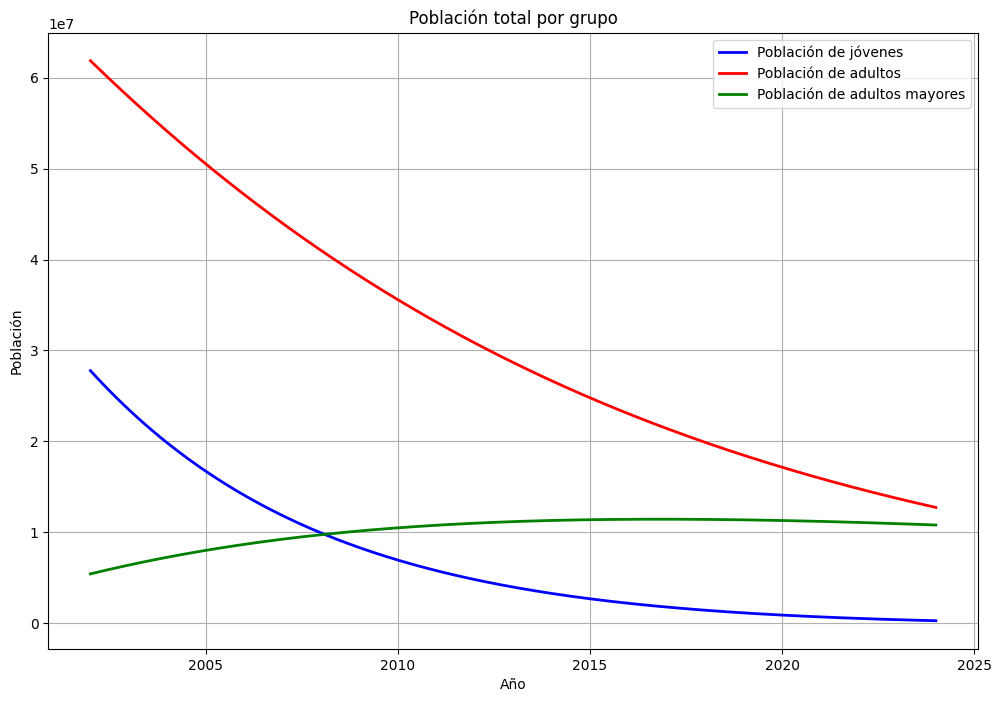

In [42]:
# Graficacion

import numpy as np
import matplotlib.pyplot as plt

def sistema_edos(t, y):
    # y = [J, A, E]
    jt, at, et = y

    # COEFICIENTES
    c1 = -0.0050  # tasa de natalidad
    c2 = 0.0897  # tasa de mortalidad jóvenes
    c3 = 0.0553  # tasa de mortalidad adultos (positiva)
    c4 = 0.0380 # tasa de mortalidad mayores

    # ECUACIONES
    dyJ = c1*at - c2*jt - (1/15)*jt
    dyA = (1/50)*jt - c3*at - (1/50)*at
    dyE = (1/50)*at - c4*et
    return [dyJ, dyA, dyE]

def RK4(func, y0, t0, tf, h):
    t_values = np.arange(t0, tf + h, h)
    n = len(t_values)
    y_values = np.zeros((n, len(y0)), dtype=float)
    y_values[0] = y0

    for i in range(1, n):
        k1 = np.array(func(t_values[i-1], y_values[i-1]))
        k2 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k1/2))
        k3 = np.array(func(t_values[i-1] + h/2, y_values[i-1] + h*k2/2))
        k4 = np.array(func(t_values[i-1] + h,   y_values[i-1] + h*k3))
        y_values[i] = y_values[i-1] + h*(k1 + 2*k2 + 2*k3 + k4)/6

    return t_values, y_values

# y0 = [J, A, E] en 2002
y0 = [27773497,61886631,5399307]
t0, tf, h = 0, 22, 0.01

t, y = RK4(sistema_edos, y0, t0, tf, h)

years = 2002 + t
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(years, y[:, 0], 'b-', linewidth=2, label='Población de jóvenes')
ax.plot(years, y[:, 1], 'r-', linewidth=2, label='Población de adultos')
ax.plot(years, y[:, 2], 'g-', linewidth=2, label='Población de adultos mayores')
ax.set_title('Población total por grupo')
ax.set_xlabel('Año')
ax.set_ylabel('Población')
ax.grid(True)
ax.legend()
plt.show()